In [42]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
#standard imports
import pandas as pd 
import numpy as np 
# from tqdm.notebook import tqdm
# tqdm.pandas(desc='progress-bar')
import matplotlib.pyplot as plt 
import math

#text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
# nltk.download('punkt') #first time downloads
# nltk.download('stopwords') #first time downloads
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
stopwords = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
import re
import string

#bokeh imports
import bokeh
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource, Slope, Label
from bokeh.io import output_notebook

# !python -m spacy download en #first time downloads
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

#settings
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.3f' %x)
import multiprocessing
cores = multiprocessing.cpu_count()
output_notebook()

Loading BokehJS ...

In [21]:
df = pd.read_csv('dtps://www.dropbox.com/s/inkzg6vb5cnnz5c/modeling.csv?dl=1')
df = df.rename(columns = {'posts':'posts_from_user','suicidal':'user_is_suicidal'})

In [22]:
stokens = []
dtokens = []
for i,r in df.iterrows():
    token = r['text'].split(' ')
    if r['user_is_suicidal']==1:
        stokens.extend(token)
    else:
        dtokens.extend(token)

In [25]:
dtoken_count = Counter(dtokens)
stoken_count = Counter(stokens)


Text(0.5, 1.0, 'Suicidal Word Cloud')

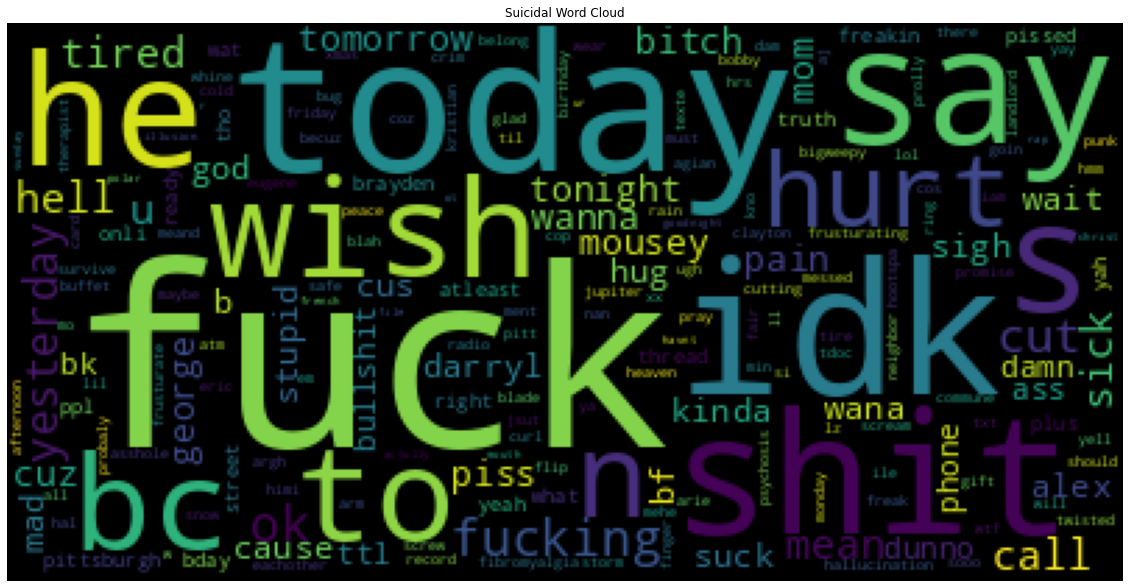

In [39]:
s_word_cloud = stoken_count - dtoken_count 
d_word_cloud = dtoken_count - stoken_count 
wc_top = WordCloud().generate_from_frequencies(s_word_cloud)
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wc_top)
plt.title('Suicidal Word Cloud')

Text(0.5, 1.0, 'Depression Word Cloud')

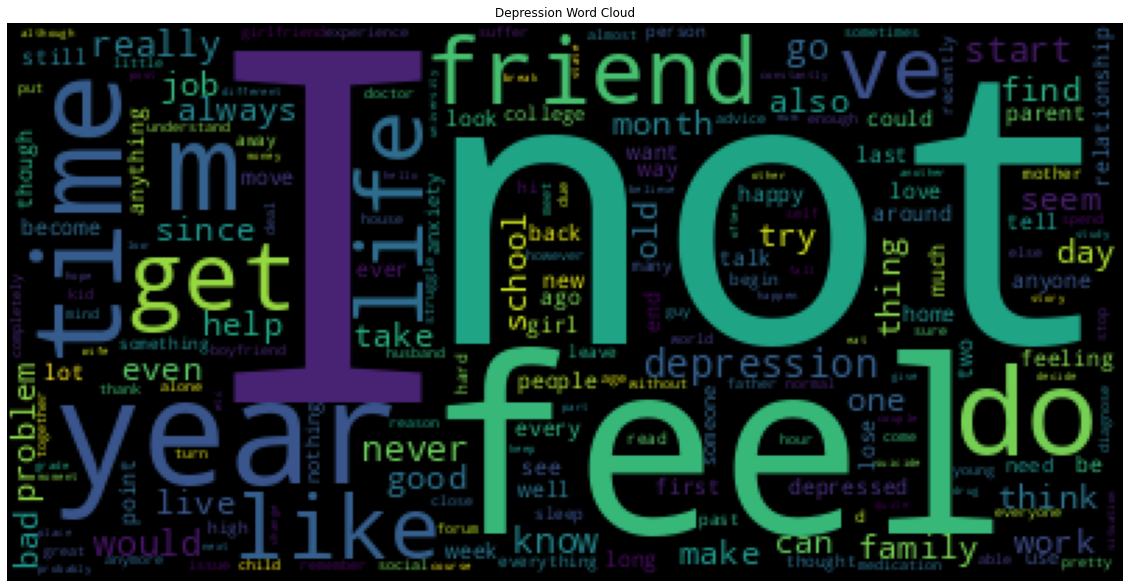

In [41]:
wc_top = WordCloud().generate_from_frequencies(d_word_cloud)
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wc_top)
plt.title('Depression Word Cloud')

In [52]:
df_s = df[df['user_is_suicidal']==1]
df_d = df[df['user_is_suicidal']==0]

In [60]:
# using min_df = 10 to ignore terms that occur in less than 10 documents for memory reasons
# you can also set a max df as a float, e.g .5 will exclude terms tad occur in > 50% of documents

#true tfidf vectorizing
cvt = TfidfVectorizer(ngram_range=(1,1),min_df=10)

X_all = cvt.fit_transform(df_s['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_s['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

s_tfidf_ngram = X.sum(axis=0)

# fake tfidf vectorizing
cvt = TfidfVectorizer(ngram_range=(1,1),min_df=10)
X_all = cvt.fit_transform(df_d['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_d['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

d_tfidf_ngram = X.sum(axis=0)

# true count vectorizing
cvt = CountVectorizer(ngram_range=(1,1),min_df=10)

X_all = cvt.fit_transform(df_s['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_s['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

s_count_ngram = X.sum(axis=0)

# fake count vectorizing
cvt = CountVectorizer(ngram_range=(1,1),min_df=10)
X_all = cvt.fit_transform(df_d['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_d['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

d_count_ngram = X.sum(axis=0)

/Users/yonilevine/Desktop/Penn_SEAS_MCIT/BigDataMCIT5450/Big_Data_Homework/MCIT545-Final-Project/final_project_venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/yonilevine/Desktop/Penn_SEAS_MCIT/BigDataMCIT5450/Big_Data_Homework/MCIT545-Final-Project/final_project_venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/yonilevine/Desktop/Penn_SEAS_MCIT/BigDataMCIT5450/Big_Data_Homework/MCIT545-Final-Project/final_project_venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is de

In [61]:
#creating data frame with tfidf values
true = pd.DataFrame(s_tfidf_ngram,columns=['true_tfidf'])
fake = pd.DataFrame(d_tfidf_ngram,columns=['fake_tfidf'])

#adding count values
true['true_count'] = s_count_ngram
fake['fake_count'] = d_count_ngram

#adding log scale of tfidf. You can add an offset to the result to account for negative values
#that occur when your TFIDF is between 1 and 0
true['true_log'] = [math.log(result) + 3 for result in true['true_tfidf']]
fake['fake_log'] = [math.log(result) + 3 for result in fake['fake_tfidf']]

In [62]:
full_joined = true.join(fake,how='outer')
full_joined = full_joined.fillna(0)
full_joined['word'] = full_joined.index

In [63]:
#play around with the cutoff values and logic
joined = full_joined[(full_joined.true_count > 10) | (full_joined.fake_count > 10) ]

In [64]:
def addManualLabel(word, x, y):
    mytext = Label(x = x, y = y, text = word.capitalize(),\
        text_font_size = '10pt', text_font_style = 'bold')
    
    p.add_layout(mytext)

In [84]:
#defining fake and true keywords
#first run the chart decide what words you want to label and 
#add them to the correct list then rerun the cell below

s_keywords = ['shit','fuck','idk','hurt']
d_keywords = ['wellbutrin','intimate','currently','thanks','exwife','therapy']

In [85]:
#defining data source
df_source = ColumnDataSource(joined)

#defining figure, title for chart and axes, and plot size
p = figure(title = "Difference in word usage between posts in Suicide and Depression",\
    x_axis_label = "Word Usage in Depression",\
    y_axis_label =  "Word Usage in Suicide")

p.scatter(x = "fake_log", y = "true_log", source = df_source,\
    fill_color = "blue", fill_alpha = .4)
#chart popups
hover = HoverTool()

hover.tooltips = [
    ("Word","@word"), #popup label and @columnname
    ("Depression Count", "@fake_count"),
    ("Suicide Count", "@true_count")
]

p.add_tools(hover)

#creating sloped line
gradient = 1
y_intercept = 0

slope = Slope(gradient = gradient, y_intercept = y_intercept,\
    line_color = 'black', line_dash = 'dashed', line_width = 3.5)


p.add_layout(slope)

#adding labels

#if the chart throws an error at this point uncomment the print statement and see
#which word is throwing the error 

for index, row in joined.loc[s_keywords].iterrows():
    # print(row['word'],row['true_log'], row['fake_log'])
    
    mytext = Label(x = row['fake_log'], y = row['true_log'],\
        text = row['word'].capitalize(), text_font_size = '10pt',\
        text_font_style = 'bold')

    p.add_layout(mytext)

for index, row in joined.loc[d_keywords].iterrows():
    # print(row['word'],row['true_log'], row['fake_log'])
    
    mytext = Label(x = row['fake_log'], y = row['true_log'],\
        text = row['word'].capitalize(), text_font_size = '10pt',\
        text_font_style = 'bold')

    p.add_layout(mytext)

# you can add manual labels for a word for stylistic reasons
# addManualLabel("manual test",9,4)


#adding large labels
mytext = Label(x = 6, y = .5, text = "Depression",\
    text_font_size = '24pt', render_mode = "canvas")

p.add_layout(mytext)

mytext = Label(x = 0, y = 8, text = "Suicide",\
    text_font_size = '24pt', render_mode = "canvas")

p.add_layout(mytext)

show(p)